# Vanadium Redox Flow Battery Stack Model

This is the implementation of Christian Blanc and co-workers's electrochemical Stack model from [sp] ["Understanding the Vanadium Redox Flow Batteries"](https://cdn.intechopen.com/pdfs/12523/InTech-Understanding_the_vanadium_redox_flow_batteries.pdf). Figure and table numbers are with respect to that document. The notebook recreates:
  * figure 3a (nernst potential as a function of state of charge) 
  * figure 8a (stack voltage as a function of current) power as a function of
    current
  * table 4
  
Citation for Blanc *et al*:

    Blanc, Christian, and Alfred Rufer. 2010. “Understanding the Vanadium Redox Flow Batteries.” In Paths to Sustainable Energy, edited by Artie Ng, 333–58. InTech. https://doi.org/10.5772/13338. 

**Example Figure 8a**:
![Figure 8a](Voltage.png)


---

## Contents

  * [Preamble](#Preamble)
  * [Functions](#Functions)
    * [ccell_i](#ccell_i)
    * [cin_i](#cin_i)
    * [concentrations](#concentrations)
    * [cycle](#cycle)
    * [nernst](#nernst)
    * [proton_concentration](#proton_concentration)
    * [species_sign](#species_sign)
    * [soc_fun](#soc_fun)
  * Figures
    * [Figure 3A](#Figure-3A)
    * [Figure 8 and Table 4](#Figure-8-and-Table-4)

---

## Preamble

Here we import the modules, declare some formatting parameters, instantiate constants and model inputs

In [34]:
from numpy import array,log,linspace,concatenate,mean
import matplotlib.pyplot as plt 
import matplotlib
#==============
# Formatting
#==============
colors = 'rgbcmyk'
plt.rcParams['axes.grid'] = True          # Toggles plot gridlines for all figures 
plt.rcParams['grid.linestyle'] = '-.'     # makes gridlines -. style
plt.rcParams['font.family'] = "Times"     # Times font
plt.rcParams['font.size'] = 20            # Font size
#==============
# Constants
#==============
F   = 96485.3328959                       # Faraday constant
Ru  = 8.314459                            # universal gas constant
T   = 298.15                              # page 336
E0  = 1.23                                # V (page 336 V equation 10)
dt  = 100
#==============
# Model Inputs
#==============
n_cell          = 19                      # number of cells
Rcharge         = .037                    # internal resistance during charging / ( ohm )
Rdischarge      = .039                    # internal resistance during discharging / ( ohm )
flowRate        = 2                       # flow rate / ( L / s )
Cvanadium       = 2                       # electrolyte vanadium concentration ( M )
tankSize        = 83                      # tank volume ( L )

---

## Functions

### *nernst*

Evaluates equation 3

In [37]:
def nernst(E0,
           CV2, 
           CV3, 
           CV4, 
           CV5, 
           CH2):                
    return(E0+(Ru*T/F)*log((CV5*CH2**2/CV4)*(CV2/CV3)))

### *species_sign*

This function evaulates equation 16. It is called by [cin_i](#cin_i) and
[cout_i](#cout_i)

In [38]:
def species_sign(species):
    if species in ["V2","V5"]:
        return(-1)
    elif species in ["V3","V4"]:
        return(1)

### *cin_i*

This is the concentration entering the cell. This function evaluates equation
15 for constant current

In [39]:
def cin_i(current,
          species,
          Volume, 
          C_init, 
          time):
    b = species_sign(species)
    return(C_init+1/Volume*(b/F)*current*time)

### cout_i

This is the concentration exiting the cell. This function evaluates equation 17

In [40]:
def cout_i(cin_i,                              
           species, 
           Ncell, 
           current, 
           flowRate):  
    b = species_sign(species)
    return(cin_i + b*(Ncell/F)*current/flowRate)

### *ccell_i*

This function returns the average concentration in the cell evaluates equation 18.

In [41]:
def ccell_i(cin_i,
            cout_i):                              
    return((cin_i+cout_i)/2)

### *soc_fun*

*soc_fun* returns the state of charge as a percent. Evaluating equation 22. 

In [42]:
def soc_fun(CV2,
            CV3):
    return(100*CV2/(CV2+CV3))

### *concentrations*

This function returns all of the individual species concentrations as a
function of the state of charge and the Vanadium concentration.

In [43]:
def concentrations(SoC,                             
                   concentrationTotal):
    Cv2 = concentrationTotal*(SoC/100)
    Cv3 = concentrationTotal*(1-SoC/100)
    Cv4 = concentrationTotal*(1-SoC/100)
    Cv5 = concentrationTotal*(SoC/100)
    return(Cv2,Cv3,Cv4,Cv5)

### *proton_concentration*

This value is estimated from the proton concentration values in Fig 3.

In [44]:
def proton_concentration(SoC):                       
    return(SoC/100+6)

### *cycle*

This function calculates the voltage for a cycle of charging or discharging; 

### cycle inputs

#### The input arguments are:

  * the intial State of charge (**SoC_init**)
  * cutoff state of charge (**cutoff_SoC**)
  * specify charge or discharge (**ch_dch**)
  * concentration of Vanadium (**concentration_init**)
  * volumetric flow rate ( L / s) (**flow_rate**)
  * Internal resistance ( Ohm ) (**R_internal**)
  * number of cells in the stack (**n_cell**)
  * time step ( s )         [I wasn't exactly sure how this worked when i wrote
it, so you can probably just vectorize this equation and not use a while loop]
  * imposed current ( A )
  * Volume of each electrolyte 
  * debug flag

In [45]:
def cycle(      SoC_init,
                cutoff_SoC,
                ch_dch, 
                concentration_init, 
                flow_rate,
                R_internal = 1,
                n_cell = 1,
                dt = 1, 
                current = 10,
                Volume = 83,
                debug = False):
    # the convention is for the current to be positive during discharging
    if ch_dch == 'ch':
        current*=-1
    elif ch_dch == 'dch':
        current*=1
    # this is the equivalent volume that gets modified per cell in the stack
    VolumePerCell = tankSize/n_cell
    # resistance of stack
    U_internal = current*R_internal
    StateOfCharge = SoC_init
    # intial concentrations of each species based on input SoC
    Cv2_i,Cv3_i,Cv4_i,Cv5_i = concentrations(SoC_init, concentration_init)
    # Proton concentration is a function of state of charge
    CH2 = proton_concentration(SoC_init)
    # j is an iterator variable
    j = 0
    time = []
    Ustack = []
    #--------------------------------------------------------------------------
    # this steps the concentrations forward in time since at different currents
    # they take different amounts of time
    #--------------------------------------------------------------------------
    while (StateOfCharge <= cutoff_SoC if ch_dch == 'ch' else StateOfCharge >= cutoff_SoC):
        # concentraiton at inlet
        Cv2_in = cin_i(current, 'V2', VolumePerCell, Cv2_i, dt*j)
        Cv3_in = cin_i(current, 'V3', VolumePerCell, Cv3_i, dt*j)
        Cv4_in = cin_i(current, 'V4', VolumePerCell, Cv4_i, dt*j)
        Cv5_in = cin_i(current, 'V5', VolumePerCell, Cv5_i, dt*j)

        # concentraiton at outlet
        Cv2_out = cout_i(Cv2_in, 'V2', n_cell, current, flow_rate)
        Cv3_out = cout_i(Cv3_in, 'V3', n_cell, current, flow_rate)
        Cv4_out = cout_i(Cv4_in, 'V4', n_cell, current, flow_rate)
        Cv5_out = cout_i(Cv5_in, 'V5', n_cell, current, flow_rate)

        # Avg concentration in the cell
        Cellv2 = ccell_i(Cv2_in,Cv2_out)
        Cellv3 = ccell_i(Cv3_in,Cv3_out)
        Cellv4 = ccell_i(Cv4_in,Cv4_out)
        Cellv5 = ccell_i(Cv5_in,Cv5_out)

        StateOfCharge = soc_fun(Cv2_in,Cv3_in)
        # update the proton concentration
        CH2 = proton_concentration(StateOfCharge)
        # calculate the nernst potential of the electrolyte
        Vnernst = nernst(E0,Cellv2,Cellv3,Cellv4,Cellv5,CH2)
        # calculate the stack voltage  Equation 2 (the internal voltage is
        # distributed over all of the cells so it is normalized here
        Ustack.append(Vnernst-U_internal/n_cell)
        time.append(dt*j)
        j+=1 
    return(array(Ustack),array(time)/3600)

---

## Figure 3A 

For this figure the SoC is varied from ~0 to ~100 % and the nernst potential at
each concentration is calcualted, so the absolute concentrations are not
important in this context, just the relative concentrations

Text(0.5, 0, 'State of Charge ( % )')

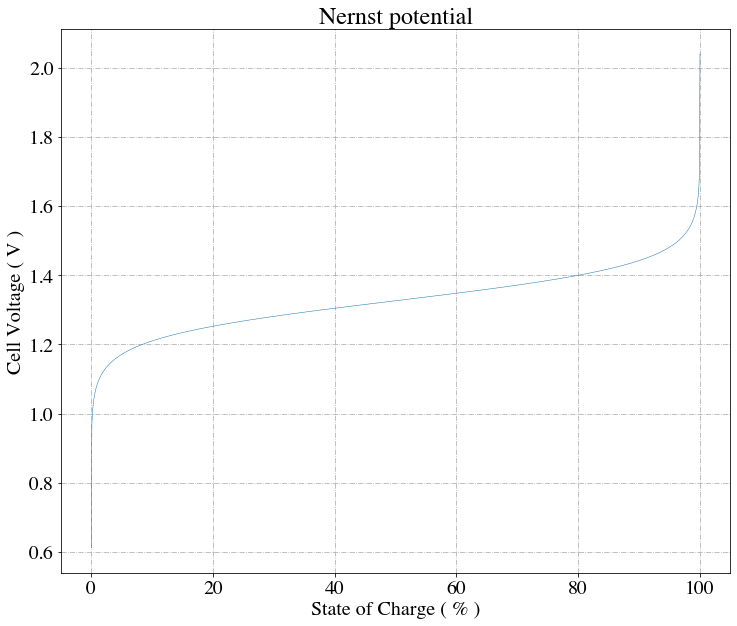

In [46]:
offset = .000001          # this avoids division by zero
Cv2,Cv5 = linspace(offset,1-offset,1000),linspace(offset,1-offset,1000)
Cv3 = 1-Cv2
Cv4 = 1-Cv5
SoCs = soc_fun(Cv2,Cv3)
Ch2s = proton_concentration(SoCs)
potentials = nernst(E0,Cv2,Cv3,Cv4,Cv5,Ch2s)
plt.figure(0, figsize = (12,10))
plt.title('Nernst potential')
plt.plot(SoCs,potentials, linewidth = .5)
plt.ylabel('Cell Voltage ( V )')
plt.xlabel('State of Charge ( % )')

## Figure 8 and Table 4

Table 4 and Figure 8 are composed inside of the same loop.  

--------------------------------------------------
Table 4
--------------------------------------------------
	current = 10
	voltage efficiency = 0.9700693106204407
	coulombic efficiency = 1.0
	energy efficiency = 0.9700693106204407
    ----------------------------------------
	current = 20
	voltage efficiency = 0.9407068082159996
	coulombic efficiency = 1.0
	energy efficiency = 0.9407068082159996
    ----------------------------------------
	current = 40
	voltage efficiency = 0.8844323666763548
	coulombic efficiency = 1.0
	energy efficiency = 0.8844323666763548
    ----------------------------------------
	current = 60
	voltage efficiency = 0.8318737500372234
	coulombic efficiency = 1.0
	energy efficiency = 0.8318737500372234
    ----------------------------------------
	current = 80
	voltage efficiency = 0.7807457754686918
	coulombic efficiency = 1.0
	energy efficiency = 0.7807457754686918
    ----------------------------------------
	current = 100
	voltage efficiency = 0.73284837187

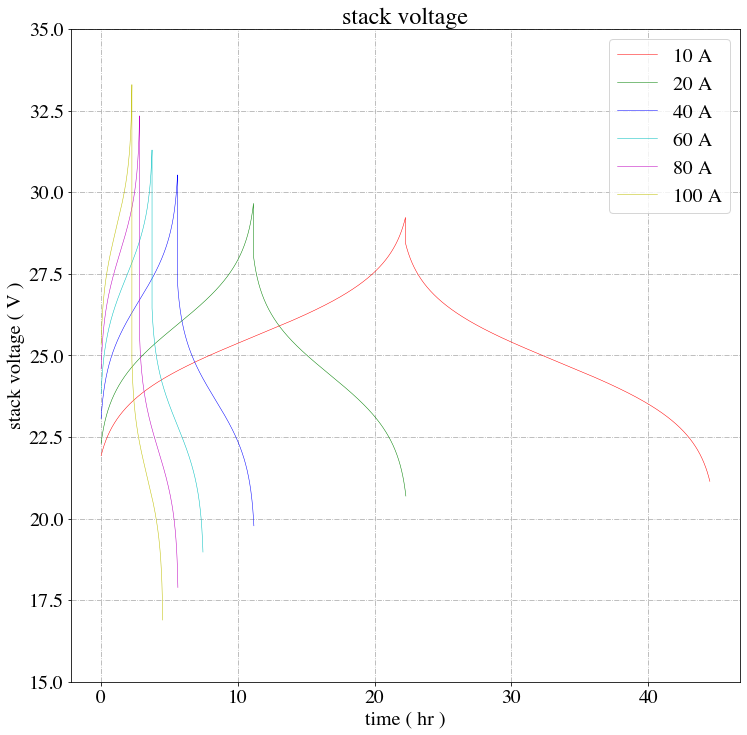

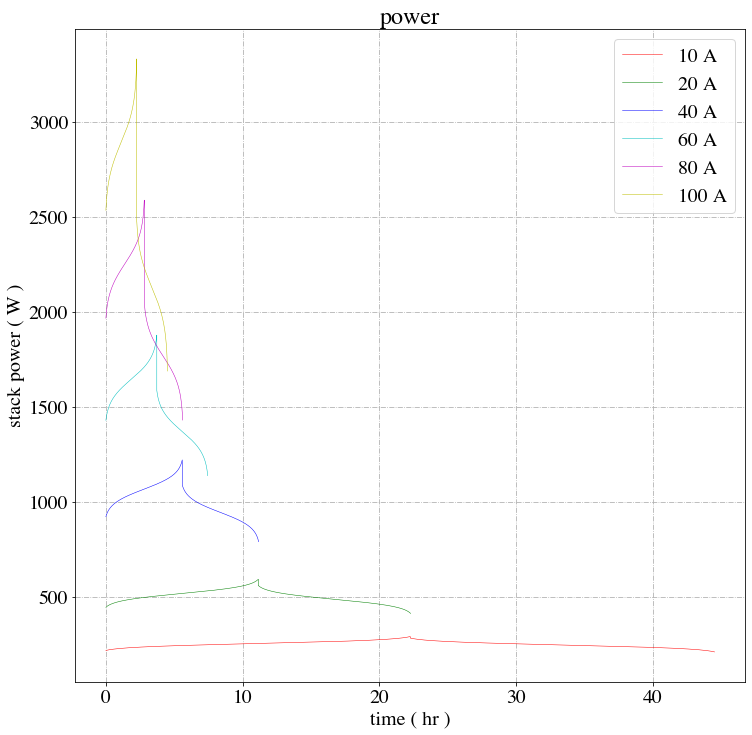

In [47]:

fig = plt.figure(1, figsize = (12,12))
plt.figure(2, figsize = (12,12))
currents = [10,20,40,60,80,100]
# this for loop iterates over the differnt current inputs
print("-"*50)
print("Table 4")
print("-"*50)
for j,current in enumerate(currents):
    # calculate the charge voltage and time
    chargeV,chargeTime = cycle(     2.5, 
                                    97.5,
                                    'ch', 
                                    Cvanadium, 
                                    flowRate, 
                                    R_internal = Rcharge,
                                    n_cell = n_cell,
                                    dt = dt, 
                                    current = current, 
                                    Volume = tankSize,
                                    debug = True)

    # calculate the discharge voltage and time
    dchargeV,dchargeTime = cycle(   97.5,
                                    2.5,
                                    'dch', 
                                    Cvanadium, 
                                    flowRate, 
                                    R_internal = Rdischarge,
                                    n_cell = n_cell,
                                    dt = dt, 
                                    current = current, 
                                    Volume = tankSize,
                                    debug = False)

    # time for charge and dischage together
    time = concatenate([chargeTime,chargeTime[-1]+dchargeTime])
    # voltage of charge and discharge
    voltage = concatenate([chargeV,dchargeV])
    plt.figure(1)
    plt.plot(time,voltage*n_cell,
                color = colors[j], 
                linewidth = .5,
                label = '{} A'.format(current))
    plt.figure(2)
    plt.plot(time,voltage*n_cell*current,
                color = colors[j], 
                linewidth = .5,
                label = '{} A'.format(current))
    # Calculate efficiencies
    eta_v = mean(dchargeV)/mean(chargeV)
    eta_coulomb = current*dchargeTime[-1]/(current*chargeTime[-1])
    eta_energy = eta_v*eta_coulomb
    # this prints the contents of table 4
    print("\tcurrent = {}".format(current))
    print("\tvoltage efficiency = {}".format(eta_v))
    print("\tcoulombic efficiency = {}".format(eta_coulomb))
    print("\tenergy efficiency = {}".format(eta_energy))
    print("   ","-"*40)
print("-"*50)

# these lines are just formatting for figures 1 and 2
for j in [1,2]:
    plt.figure(j)
    plt.xlabel('time ( hr )')
    plt.legend()
plt.ylabel('stack power ( W )')
plt.title('power')

plt.figure(1)
plt.ylim(15,35)
plt.ylabel('stack voltage ( V )')
plt.title('stack voltage')
plt.show()

fig.savefig("Voltage.png",dpi = 300)